In [1]:
%load_ext autoreload
%autoreload 2

## Calibrate Camera and save data needed to undistort

- calibrate
- save undistortion variable
- undistort test image

In [2]:
import pickle
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from src.calibrate import calibrate_coeffs

mtx, dist = calibrate_coeffs(directory='camera_cal', rows=6, cols=9)
mtx_dist = {
    'mtx': mtx,
    'dist': dist
}

# save variables
with open('mtx_dist.pickle', 'wb') as handle:
    pickle.dump(mtx_dist, handle, protocol=pickle.HIGHEST_PROTOCOL)

# undistort 'test1.jpg'
img = mpimg.imread('test_images/test1.jpg')
undist = cv2.undistort(img, mtx, dist, None, None)

mpimg.imsave('output_images/test1_undistorted.jpg', undist)

(1280, 720)


## Pipeline

- in cell where each step of image is saved
- as function in order to apply it as a whole

5376.7088795667605
5081.393990674068


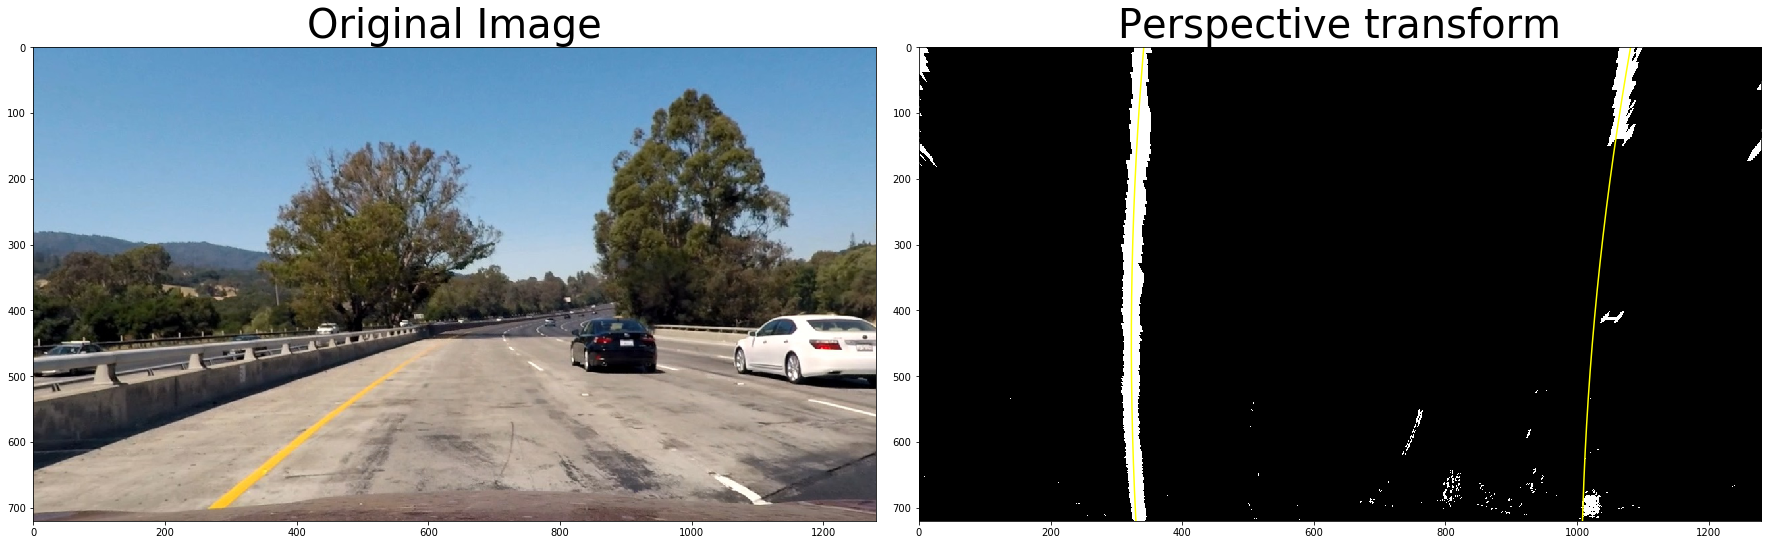

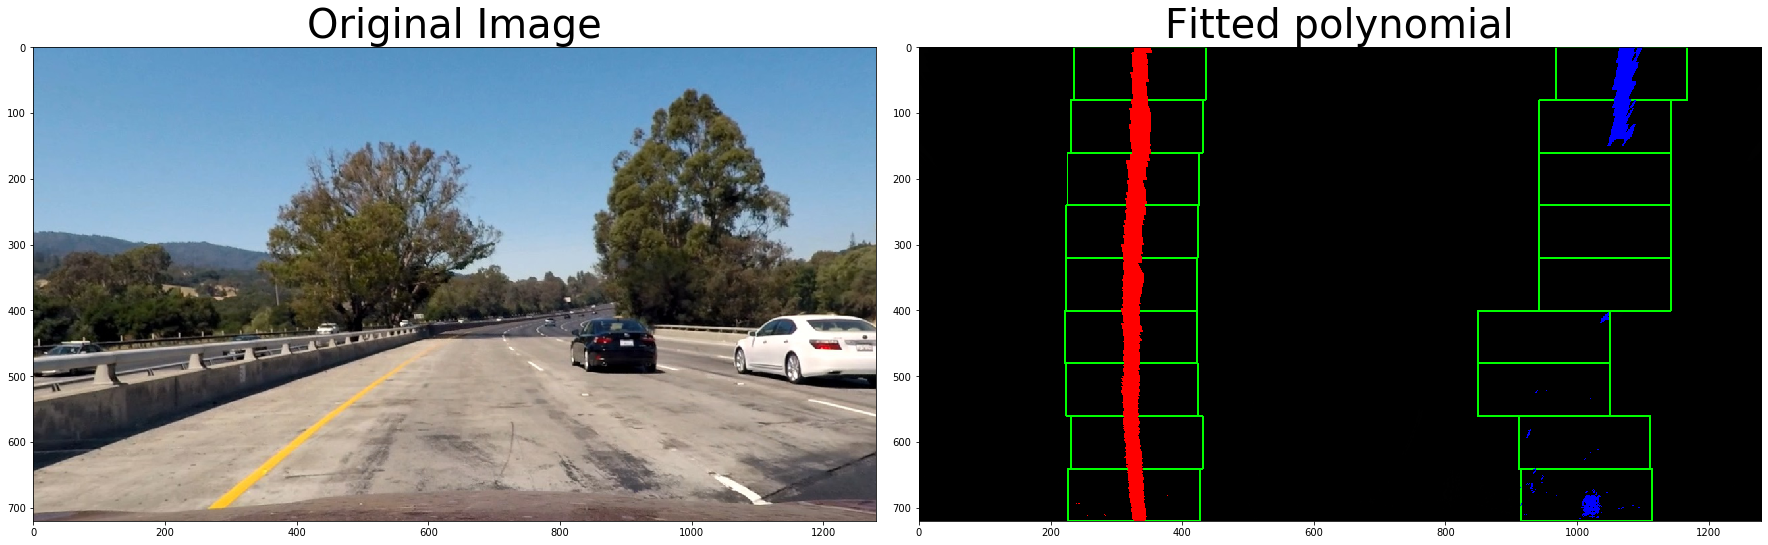

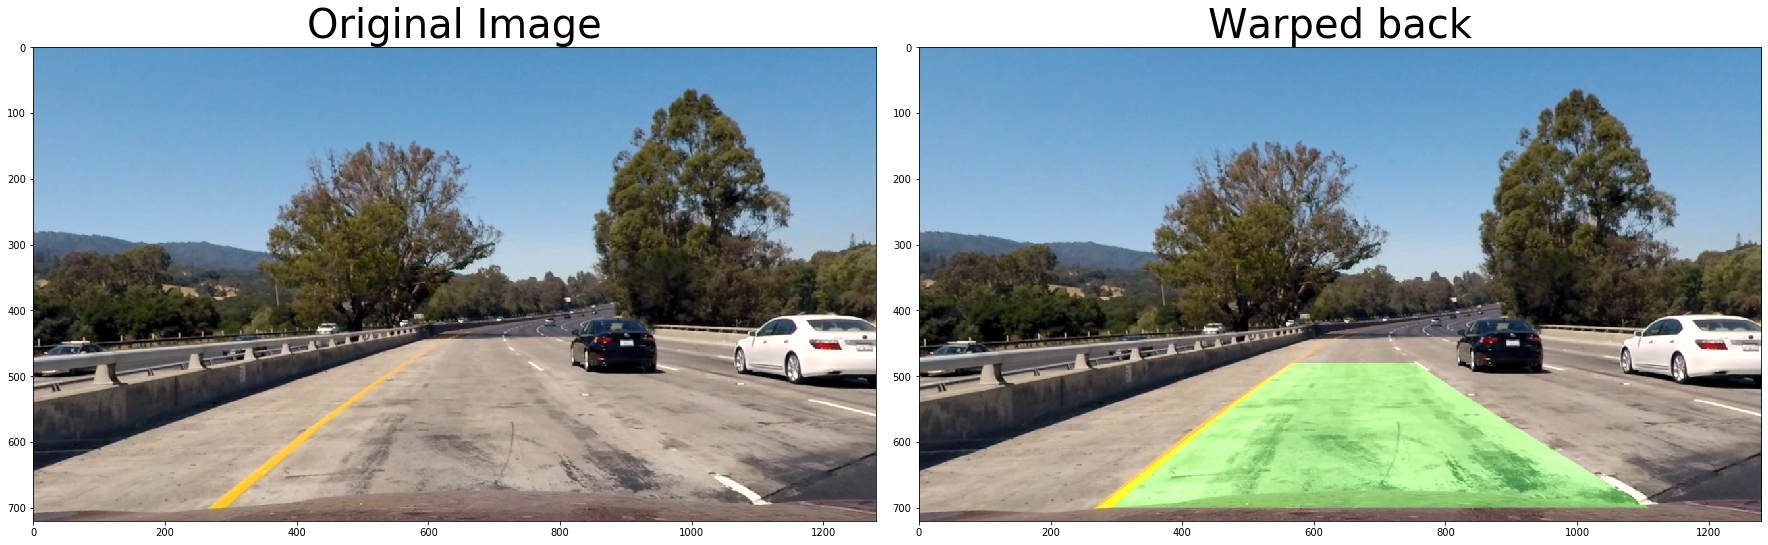

In [3]:
from src.gradient import create_gradient_img
from src.warp import perspective_transform, warp_back
from src.find_lane_pxl import fit_polynomial, measure_curvature
from src.utils import plot_2_img
import matplotlib.image as mpimg
import cv2
import numpy as np

image_name = 'test1'

img = mpimg.imread('test_images/{}.jpg'.format(image_name))
#img = mpimg.imread('test_images/straight_lines1.jpg')#
img_size = (img.shape[1], img.shape[0])


with open('mtx_dist.pickle', 'rb') as handle:
    mtx_dist = pickle.load(handle)
mtx = mtx_dist["mtx"]
dist = mtx_dist["dist"]

# undistort
undist = cv2.undistort(img, mtx, dist, None, mtx)
#plot_2_img(img, undist, 'Undistorted')
mpimg.imsave('output_images/{}_undistorted.jpg'.format(image_name), undist)

# apply threshholding
binary = create_gradient_img(undist)
#plot_2_img(undist, binary, 'Color Gradient')
mpimg.imsave('output_images/{}_binary.jpg'.format(image_name), binary, cmap='gray')

# perspectrive transform
binary_warped, M, Minv = perspective_transform(binary)
plot_2_img(undist, binary_warped, 'Perspective transform')
mpimg.imsave('output_images/{}_binwarped.jpg'.format(image_name), binary_warped, cmap='gray')

left_curverad, right_curverad = measure_curvature(binary_warped)
print(left_curverad)
print(right_curverad)

out_img, left_fitx, right_fitx, ploty = fit_polynomial(binary_warped)
plot_2_img(undist, out_img, 'Fitted polynomial')
mpimg.imsave('output_images/{}_polynomial.jpg'.format(image_name), out_img)

newwarp = warp_back(undist, binary_warped, left_fitx, right_fitx, ploty, Minv)
plot_2_img(undist, newwarp, 'Warped back')
mpimg.imsave('output_images/{}_final.jpg'.format(image_name), newwarp)


## Put functions together and define pipeline

In [4]:
def pipeline(img):

    with open('mtx_dist.pickle', 'rb') as handle:
        mtx_dist = pickle.load(handle)
    mtx = mtx_dist["mtx"]
    dist = mtx_dist["dist"]
    # undistort
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # apply threshholding
    binary = create_gradient_img(undist)
    # perspectrive transform
    binary_warped, M, Minv = perspective_transform(binary)
    out_img, left_fitx, right_fitx, ploty = fit_polynomial(binary_warped)
    newwarp = warp_back(undist, binary_warped, left_fitx, right_fitx, ploty, Minv)
    return newwarp

## Run and save video analysis

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video ./project_video_output.mp4.
Moviepy - Writing video ./project_video_output.mp4



Moviepy - Done !
Moviepy - video ready ./project_video_output.mp4
CPU times: user 3min 41s, sys: 7.94 s, total: 3min 49s
Wall time: 2min 22s


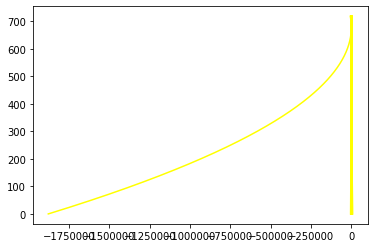

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_name = './project_video.mp4'


clip1 = VideoFileClip(video_name)
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile('./project_video_output.mp4', audio=False)

In [6]:
HTML("""
<video widthdraw_lines2(line_img, lines)="960" height="540" controls>
  <source src="{0}">
</video>
""".format('./project_video_output.mp4'))